### Libraries

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch.nn as nn
import glob
import matplotlib.tri as tri
import pandas as pd
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
import imageio
from typing import Tuple, Union
from torchsummary import summary
from tqdm import tqdm as tqdm
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import math
from scipy.interpolate import interp1d
from torch.utils.data import Dataset, DataLoader
import copy
from torchvision import transforms
import torchvision
import torch.nn.init as init
from scipy.linalg import norm
from skimage.transform import resize
import shutil
import cv2
from scipy.linalg import svd
import gzip

import shutil
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Load CFD Data

In [33]:
model = 'Sten' # or Sten
bc_name = 'Mid' # or Wall
state_lstm = 'load'  # train | load

In [34]:
data = np.load(f'/content/drive/MyDrive/Paper/RoSo/{model}/{bc_name}/rylScty_patientSpec_StenosisModel_miduvw.npz')

x = data['x']
y = data['y']
z = data['z']
v_x = data['v_x']
v_y = data['v_y']
v_z = data['v_z']
del data

In [35]:
variable = v_x.T # (loc, time)
variable_name = 'v_x'

### General Model Info

In [36]:
n_snapshots = 999

### Read BCs

In [37]:
df = pd.read_csv('/content/drive/MyDrive/Paper/RoSo/BC.csv')

#Velocity Function Interpolation
tv_values = df['t1'].tolist()
v_values = df['v'].tolist()
#Create interpolation function
interp_func = interp1d(tv_values, v_values)
# Generate 2000 uniform values
uniform_tv_values = np.linspace(min(tv_values), max(tv_values), n_snapshots)
interpolated_v_values = interp_func(uniform_tv_values)

#Pressure Function Interpolation
tp_values = df['t2'].tolist()
tp_values = [x for x in tp_values if not math.isnan(x)]
P_values = df['P'].tolist()
P_values = [x for x in P_values if not math.isnan(x)]
#Create interpolation function
interp_func = interp1d(tp_values, P_values)
#Generate 2000 uniform values
uniform_tp_values = np.linspace(min(tp_values), max(tp_values), n_snapshots)
interpolated_P_values = interp_func(uniform_tp_values)

### POD

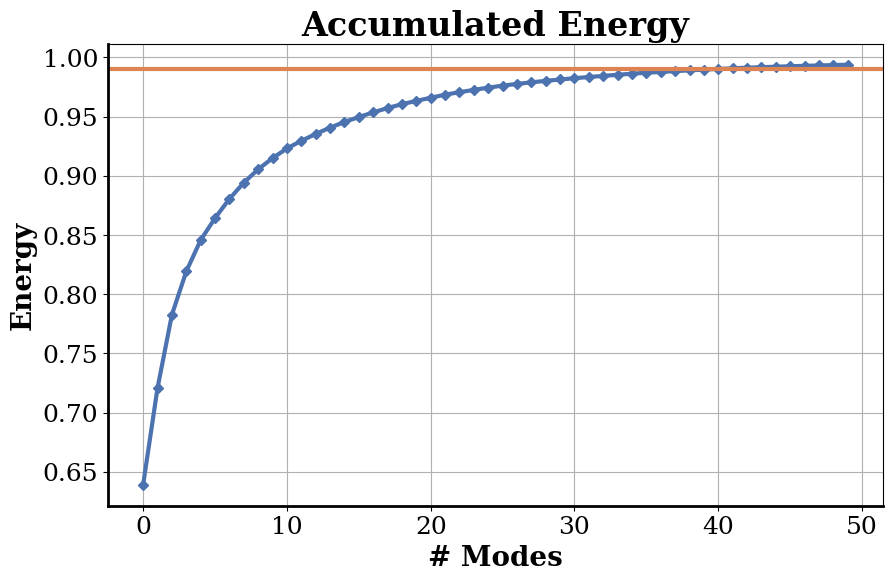

In [38]:
U, S, VT = svd(variable, full_matrices=False)

energy_retained = np.cumsum(S) / np.sum(S)


plt.rc('font', family='DeJavu Serif', size=18)
# plt.rcParams['font.family'] = 'Times New Roman'
colors = sns.color_palette('deep', n_colors=100)

plt.figure(figsize=(10, 6))
plt.plot(energy_retained[:50], color=colors[0], linewidth=3, marker='D', markersize=5, markevery=1)

ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)  # X-axis line width
ax.spines['left'].set_linewidth(2)    # Y-axis line width

plt.xlabel('# Modes', fontsize=20, weight='bold')
plt.ylabel('Energy', fontsize=20, weight='bold')

#plt.legend(frameon=True, edgecolor='black')
# handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(handles=handles, labels=labels, frameon=True, edgecolor='black', loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

plt.grid(True)
plt.axhline(y=0.99, linewidth=3, color=colors[1])
plt.title('Accumulated Energy', fontsize=24, weight='bold')
# plt.savefig('fig.jpg', dpi=400, bbox_inches='tight')
plt.show()

### Reduction

In [39]:
num_modes = 33  # correpsond to 99% energy

# Energy content calculation
total_energy = np.sum(S)
retained_energy = np.sum(S[:num_modes])
energy_content = retained_energy / total_energy * 100
print("With", num_modes, "number of modes, the energy content is:", energy_content)

With 33 number of modes, the energy content is: 98.43525042044892


In [40]:
q = U[:,:num_modes].T @ variable

variable_reconst = U[:,:num_modes] @ q

RelErr1 = np.zeros((q.shape[1]))
for t in range(q.shape[1]):
        # print(t)
        RelErr1[t] = (norm(variable[:,t] - variable_reconst[:,t])/norm(variable[:,t]) ) * 100

In [41]:
np.savez(f'/content/drive/MyDrive/Paper/RoSo/{model}/{bc_name}/POD_data_{model}_{bc_name}_{variable_name}.npz', S=S, Reconst_error=RelErr1)

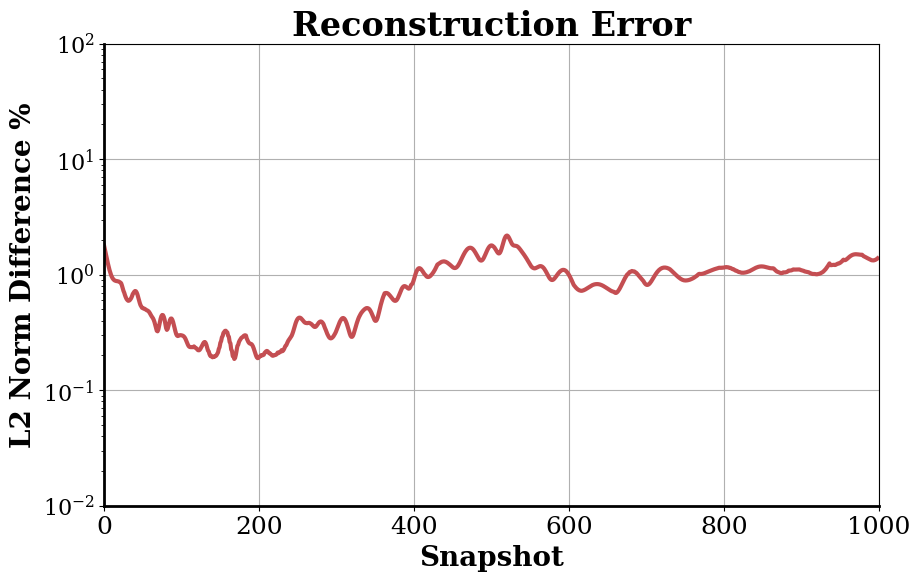

In [42]:
plt.rc('font', family='DeJavu Serif', size=18)
# plt.rcParams['font.family'] = 'Times New Roman'

plt.figure(figsize=(10, 6))
plt.plot(RelErr1, color=colors[3], linewidth=3)

ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)  # X-axis line width
ax.spines['left'].set_linewidth(2)    # Y-axis line width

plt.xlabel('Snapshot', fontsize=20, weight='bold')
plt.ylabel('L2 Norm Difference %', fontsize=20, weight='bold')

plt.yscale('log')  # Set y-axis to logarithmic scale
plt.xlim(0, 1000)  # X-axis range from 0 to 1
plt.ylim(0.01, 100)  # Y-axis range from 0.01 to 100

plt.yticks([0.01, 0.1, 1, 10, 100], fontsize=16, weight='normal')


#plt.legend(frameon=True, edgecolor='black')
# handles, labels = plt.gca().get_legend_handles_labels()
# plt.legend(handles=handles, labels=labels, frameon=True, edgecolor='black', loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=2)

plt.grid(True)


plt.title('Reconstruction Error', fontsize=24, weight='bold')

# plt.savefig('fig.jpg', dpi=400, bbox_inches='tight')
plt.show()

# LSTM

### Generating Input/Output Matrices

In [43]:
t = np.linspace(1, n_snapshots, num=n_snapshots)
inputt = np.concatenate((t.reshape(-1, 1), interpolated_v_values.reshape(-1, 1), interpolated_P_values.reshape(-1, 1), q.T), axis=1)
outputt = np.copy(q).T

### Scaling Input/Output Matrices

In [44]:
min_vals_input = np.min(inputt, axis=0)
max_vals_input = np.max(inputt, axis=0)
input_scaled = inputt - min_vals_input[np.newaxis, :]
input_scaled /= (max_vals_input - min_vals_input)[np.newaxis, :]

min_vals_output = np.min(outputt, axis=0)
max_vals_output = np.max(outputt, axis=0)
output_scaled = outputt - min_vals_output[np.newaxis, :]
output_scaled /= (max_vals_output - min_vals_output)[np.newaxis, :]

### Time Windowing (Sequencing)

In [45]:
time_window = 100

x_train = []
y_train = []

for i in range(0,len(input_scaled) - time_window -1):
    x_train.append( input_scaled[i : (i+time_window) , :] )
    y_train.append( output_scaled[i+time_window,:])

total_x = np.array(x_train)
total_y = np.array(y_train)

### Train/Test Split

In [46]:
Test_split = 0.8

x_train = total_x[:int(Test_split * total_x.shape[0]),:,:]
y_train = total_y[:int(Test_split * total_y.shape[0])]

x_test = total_x[int(Test_split * total_x.shape[0]):, :,:]
y_test = total_y[int(Test_split * total_y.shape[0]):]

# Convert data to PyTorch tensors
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

### LSTM Network

In [47]:
# Device setup
device = torch.device('cpu') if state_lstm=='load' else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Hyperparameters
input_size = num_modes + 3  # 3 = (t & v & P)
hidden_size = 512
output_size = num_modes
sequence_length = time_window
learning_rate = 0.00001
num_epochs = 200000
batch_size = 20
early_stop_patience = 100
dropout_prob = 0.2

# LSTMNet definition
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_prob):
        super(LSTMNet, self).__init__()
        self.hidden_size = hidden_size
        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers=3, batch_first=True, dropout=dropout_prob)
        self.fc1 = nn.Linear(hidden_size, output_size)

        # Initialize LSTM weights
        for name, param in self.lstm1.named_parameters():
            if 'weight' in name:
                init.xavier_normal_(param)
            elif 'bias' in name:
                init.constant_(param, 0.0)

        # Initialize linear layer weights
        init.xavier_normal_(self.fc1.weight)
        init.constant_(self.fc1.bias, 0.0)

    def forward(self, x):
        h01 = torch.zeros(3, x.size(0), self.hidden_size, device=device).requires_grad_()
        c01 = torch.zeros(3, x.size(0), self.hidden_size, device=device).requires_grad_()
        out1, (h01, c01) = self.lstm1(x, (h01.detach(), c01.detach()))
        out = nn.functional.relu(self.fc1(out1[:, -1, :]))
        return out

model_lstm = LSTMNet(input_size, hidden_size, output_size, dropout_prob).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)

Using device: cpu


### Train

In [48]:
# Move the Data to GPU
x_train = x_train.to(device)
y_train = y_train.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

In [49]:
name = f'LSTMNet_{model}_{bc_name}_{variable_name}.pt'

best_loss = float('inf')
early_stop_count = 0


if state_lstm == 'train':
    for epoch in range(num_epochs):
        model_lstm.train()
        for i in range(0, x_train.shape[0], batch_size):
            batch_x = x_train[i:i+batch_size]
            batch_y = y_train[i:i+batch_size]

            # Forward pass
            outputs = model_lstm(batch_x)

            # Compute loss and backpropagation
            loss = criterion(outputs, batch_y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluate the model on training and test data
        with torch.no_grad():
            model_lstm.eval()
            train_outputs = model_lstm(x_train)
            train_loss = criterion(train_outputs, y_train)
            test_outputs = model_lstm(x_test)
            test_loss = criterion(test_outputs, y_test)

        # Print training and test loss every epoch
        print('Epoch [{}/{}], Train Loss: {:.6f}, Test Loss: {:.6f}'.format(epoch+1, num_epochs, train_loss.item(), test_loss.item()))

        # Check if the current test loss is the best so far
        if test_loss < best_loss:
            best_loss = test_loss
            early_stop_count = 0

            torch.save(model_lstm.state_dict(), name)
            shutil.copy(name, f'/content/drive/MyDrive/Paper/RoSo/{model}/{bc_name}/')

        else:
            early_stop_count += 1
            if early_stop_count == early_stop_patience:
                print('Early stopping after {} epochs'.format(epoch+1))
                break

elif state_lstm == 'load':
    state_dict = torch.load(f'/content/drive/MyDrive/Paper/RoSo/{model}/{bc_name}/{name}', map_location=torch.device('cpu'))
    model_lstm.load_state_dict(state_dict)
    model_lstm = model_lstm.to(torch.device('cpu'))

    # Recheck the model is loaded completely!
    missing_keys, unexpected_keys = model_lstm.load_state_dict(state_dict, strict=False)
    if missing_keys or unexpected_keys:
        print("Missing keys:", missing_keys)
        print("Unexpected keys:", unexpected_keys)
    else:
        print("Model is loaded completely!")

Model is loaded completely!


<ipython-input-49-830c61203e9b>:49: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f'/content/drive/MyDrive/Paper/RoSo/{model}/{bc_name}/{name}', map_

### Inference

In [50]:
model_lstm.eval()
with torch.no_grad():
    x = x_test[0:1,:,:].cpu()
    predict = model_lstm(x)
    pred_final = []

    for i in range (1,x_test.shape[0]):
        pred_final.append(predict)
        x = x_test[i:i+1, :, :]
        x = x.to(device)
        predict = model_lstm(x)

pred_final = torch.cat(pred_final, dim=0).cpu().detach().numpy()